<a href="https://colab.research.google.com/github/ziatdinovmax/AISTEM_WORKSHOP_2020/blob/main/Day02/Ising_GP_BO_v2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process-based Bayesian optimization for Ising model

This notebook illustrates an application of Gaussian process-based Bayesian optimization (GP-BO) for the exploration of phase diagram in lattice Ising model. Specifically, we show an example of optimizing heat capacity in NNN Ising model. See our [paper](https://arxiv.org/ftp/arxiv/papers/2004/2004.04832.pdf) for more details.

The GP-BO is implemented via [GPim package](https://github.com/ziatdinovmax/GPim) built on top of PyTorch. For the introduction into Bayesian optimization, see this [review](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf)


---


*Authors: Maxim Ziatdinov, Mani Valleti, Rama K. Vasudevan and Sergei V. Kalinin*



In [ ]:
#@title Install/Import

!pip install gpim==0.3.6
!git clone https://github.com/ramav87/ising_sim

import numpy as np
import pandas as pd
from numpy.random import rand
import pickle
import os
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from scipy.stats import norm

from ising_sim.src.isingsim import IsingSim, compress_histogram, load_club_list, sd2_loss, loss_func
import gpim

np.random.seed(42)

In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we define the model:

In [ ]:
def J2_to_S_func(a):
  Jci = a[0]
  Jsi = a[1]
  Jc = 0.1*Jci - 4
  Js = 0.1*Jsi - 4

  J_mat = [[0,0,0,0,0],
            [0,norm(loc=Js, scale = 0.001),norm(loc=Jc, scale = 0.001),norm(loc=Js, scale = 0.001),0],
           [0,norm(loc=Jc, scale = 0.001),0,norm(loc=Jc, scale = 0.001),0.0],
            [0,norm(loc=Js, scale = 0.001),norm(loc=Jc, scale = 0.001), norm(loc=Js, scale = 0.001),0],
            [0,0,0.0,0,0]]

  # N in the next line is the lattice size
  ising_model =  IsingSim(N=20, J_mat = J_mat, save_trajectories=True, T = 2.0, eqSteps = 500, mcSteps = 500)
  ising_model.performIsingSim()
  st = ising_model.results['SpecificHeat']
  return st

Next we define (custom) [acquisition functions](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf) for GP-BO:

(alternatively, one can use those built into GPim package)

In [ ]:
def acquisition_function(gpmodel, X_full, X_sparse):
    mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
    acq = 5 * sd + 10 * mean # Good for heat capacity
    return acq, (mean, sd) # leave it as is

def acq2(gpmodel, X_full, X_sparse):  # leave it as is
    mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
    random_bit = np.random.rand()
    if random_bit < 0.60:
      acq = np.exp(-5 * (mean - 0)**2)
    else:
      acq = sd
    return acq, (mean, sd)  # leave it as is

Define initial seed for BO:

  1%|          | 4/500 [00:00<00:12, 38.59it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 20.95it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:13, 37.51it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 22.67it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:12, 39.06it/s]

Completed. Saving

---Performing Equlibration---



  0%|          | 2/500 [00:00<00:25, 19.80it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.11it/s]


Completed. Saving


  1%|          | 5/500 [00:00<00:12, 40.32it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:24, 20.63it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.81it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:14, 33.45it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 21.97it/s]


---Finished...
----Performing MC Moves----



  1%|          | 5/500 [00:00<00:12, 40.02it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.29it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.89it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:13, 36.99it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.48it/s]


---Finished...
----Performing MC Moves----



  0%|          | 0/500 [00:00<?, ?it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 20.88it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:13, 37.53it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 22.84it/s]


---Finished...
----Performing MC Moves----



  1%|          | 5/500 [00:00<00:11, 41.92it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.00it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:14, 34.59it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 22.71it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.00it/s]


Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.18it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.91it/s]


Completed. Saving


  1%|          | 3/500 [00:00<00:22, 22.31it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.77it/s]


Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 23.00it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:12, 39.04it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.09it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.96it/s]


Completed. Saving


  1%|          | 3/500 [00:00<00:23, 20.98it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



  0%|          | 0/500 [00:00<?, ?it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.58it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.83it/s]


Completed. Saving


  1%|          | 3/500 [00:00<00:22, 22.23it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.03it/s]


Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.49it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.05it/s]


Completed. Saving


  1%|          | 3/500 [00:00<00:23, 21.32it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:12, 38.40it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 22.96it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.78it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:13, 36.60it/s]


---Performing Equlibration---



  0%|          | 2/500 [00:00<00:27, 18.44it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.18it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 39.61it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 21.64it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.13it/s]


Completed. Saving


  1%|          | 3/500 [00:00<00:17, 28.23it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.42it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.83it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 38.68it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 23.37it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:14, 35.25it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.52it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.99it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 38.71it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:25, 19.48it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.11it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:13, 37.61it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:24, 20.65it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.77it/s]


Completed. Saving


  1%|          | 3/500 [00:00<00:22, 21.75it/s]


---Performing Equlibration---


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:14, 35.27it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 22.70it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:23<00:00, 21.63it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 38.69it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 22.66it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.86it/s]


Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.45it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.06it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:13, 36.75it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:24, 20.65it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.95it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 39.92it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 21.99it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.87it/s]


Completed. Saving


  1%|          | 5/500 [00:00<00:12, 40.76it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.20it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:13, 36.91it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 22.80it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.90it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 39.95it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.59it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:14, 33.25it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.02it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:23<00:00, 21.53it/s]


Completed. Saving

---Performing Equlibration---



  0%|          | 2/500 [00:00<00:29, 17.09it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:13, 37.58it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.15it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:13, 35.47it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 22.16it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:23<00:00, 21.38it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 38.82it/s]


---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.25it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:13, 38.11it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:20, 23.95it/s]


---Finished...
----Performing MC Moves----



  1%|          | 5/500 [00:00<00:12, 41.08it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:23, 21.43it/s]


---Finished...
----Performing MC Moves----



  1%|          | 4/500 [00:00<00:12, 38.86it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 21.83it/s]


---Finished...
----Performing MC Moves----



  1%|          | 5/500 [00:00<00:12, 40.19it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 23.54it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.06it/s]


Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:22, 21.63it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 21.92it/s]


Completed. Saving


  1%|          | 4/500 [00:00<00:12, 39.15it/s]


---Performing Equlibration---



  0%|          | 2/500 [00:00<00:24, 19.99it/s]


---Finished...
----Performing MC Moves----



  1%|          | 5/500 [00:00<00:12, 40.38it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:21, 23.52it/s]


---Finished...
----Performing MC Moves----



  1%|          | 5/500 [00:00<00:11, 44.01it/s]

Completed. Saving

---Performing Equlibration---



  1%|          | 3/500 [00:00<00:20, 23.83it/s]


---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:22<00:00, 22.11it/s]

Completed. Saving


Text(0.5, 1.0, 'Regularizer')

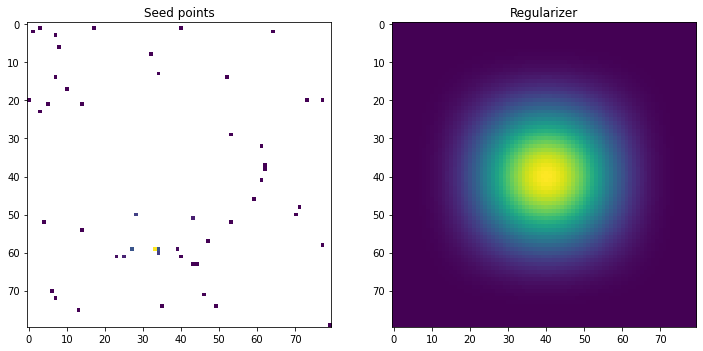

In [ ]:
size_Jc, size_Js = 80, 80
Z_sparse = np.ones((size_Jc, size_Js))*np.nan

idx = np.random.randint(0, Z_sparse.shape[0], size=(2, 50))
seeds = []
for i in range(50):
  seeds.append(np.array((idx[0,i], idx[1,i])).T) 

for i, seed in enumerate(seeds):
    Z_sparse[tuple(seed)] = J2_to_S_func(seed)

#add this matrix to avoid runaway
Val_lim = np.ones((size_Jc, size_Js))
for i in range(size_Jc):
  for j in range(size_Js):
    Val_lim[i,j] = (np.sin(np.pi*i/size_Jc)**4)*(np.sin(np.pi*j/size_Js)**4)


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(Z_sparse)
ax1.set_title('Seed points')
ax2.imshow(Val_lim)
ax2.set_title('Regularizer')

Run Bayesian optimization:

In [ ]:
# Get full and sparse grids
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)
# Initialize Bayesian optimizer with a custom acquisition function
boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    J2_to_S_func, acquisition_function=acquisition_function,
    batch_size=1000, lengthscale=[1., 40.], dscale=4,  exit_strategy=1,
    exploration_steps=650, use_gpu=True, verbose=1, save_checkpoints=True,
    filename='/content/drive/My Drive/research/Ising_BO/bo_ising_heat_acq1_e') # adjust appropriately
# Run Bayesian optimization
boptim.run()

#gpim.utils.plot_query_points(boptim.indices_all, plot_lines=True)

View results:

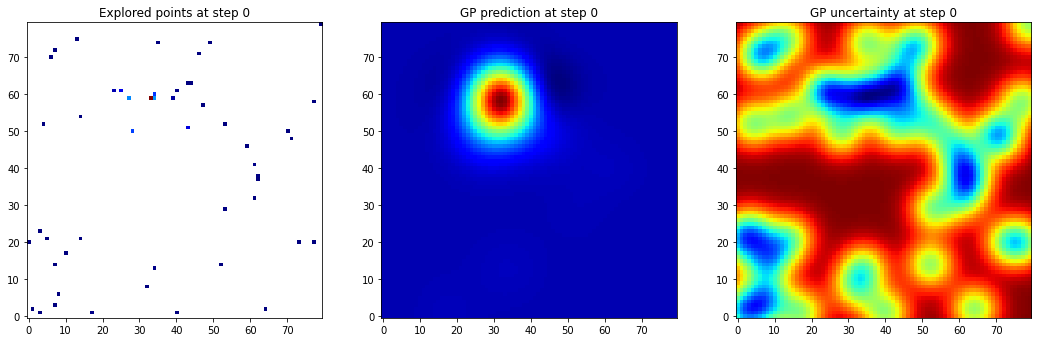

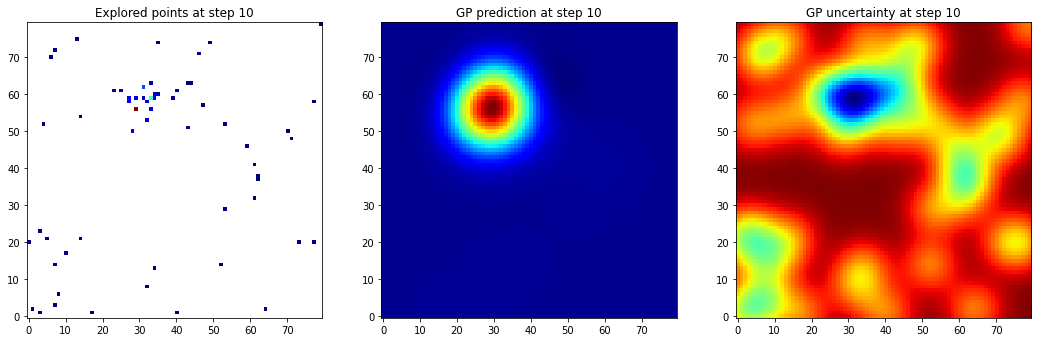

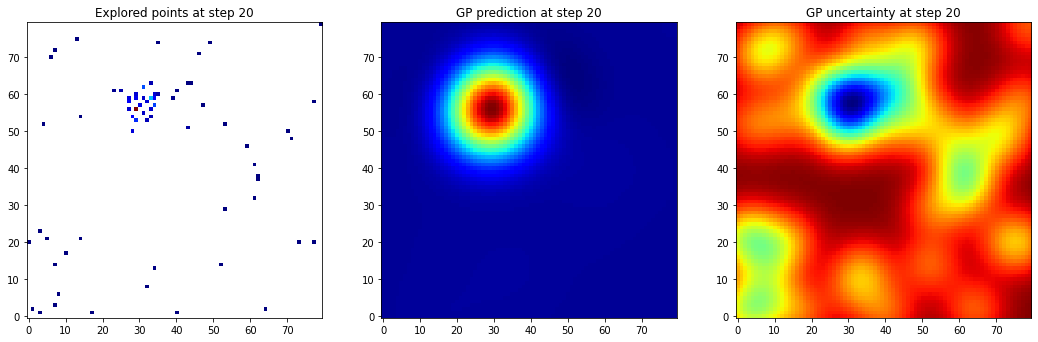

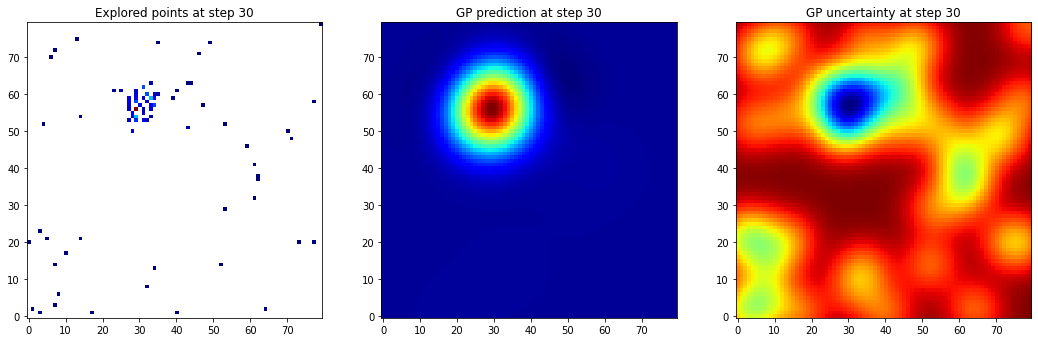

 78%|███████▊  | 388/500 [00:30<00:03, 32.63it/s]

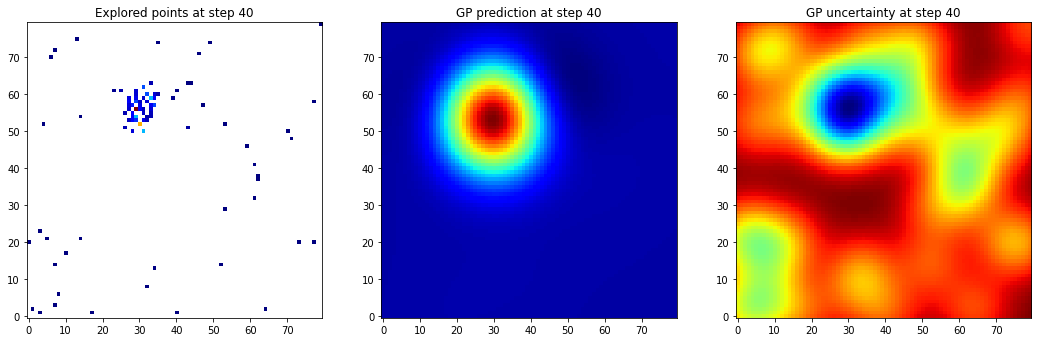

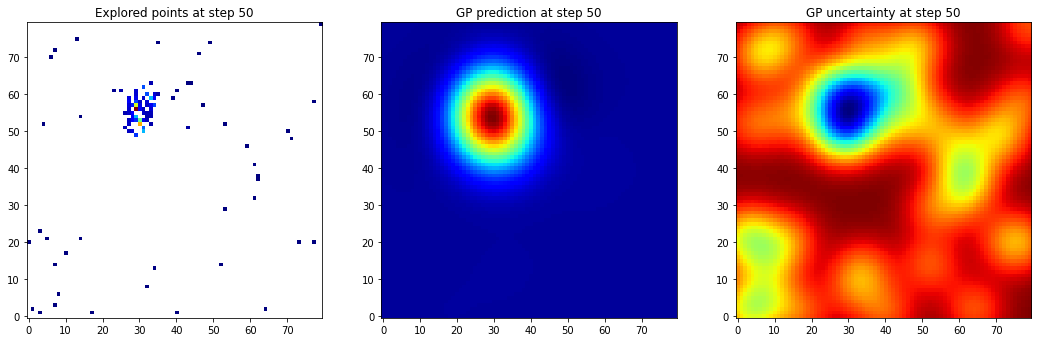

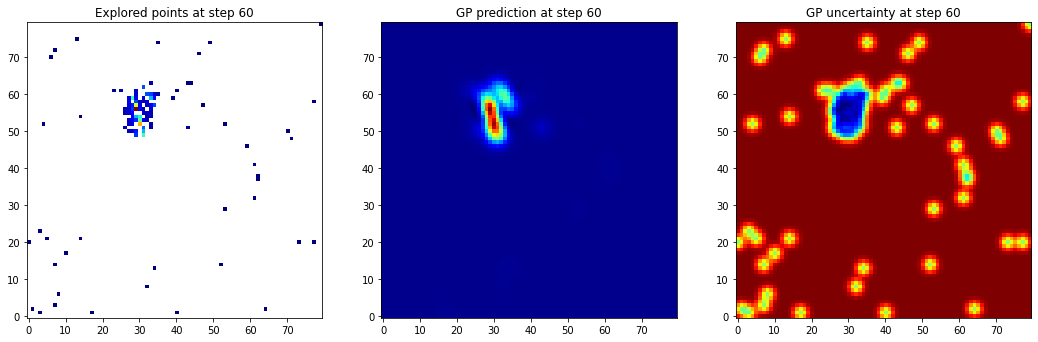

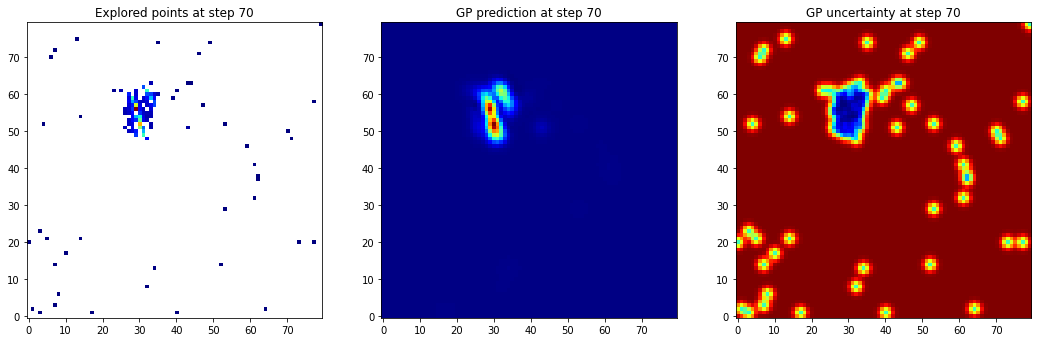

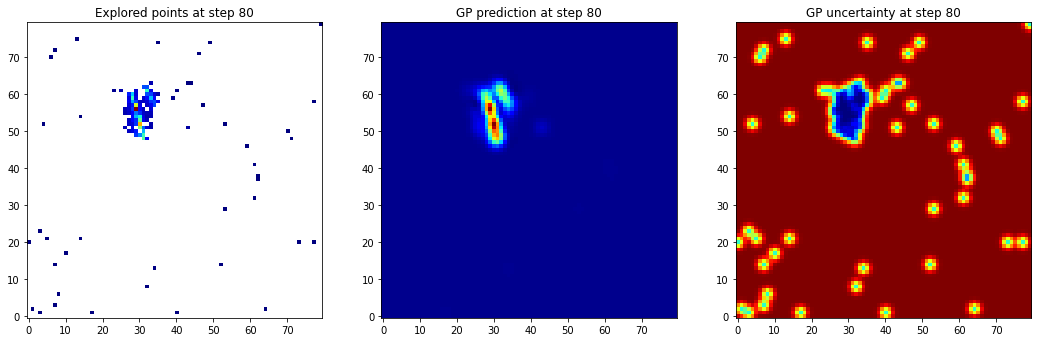

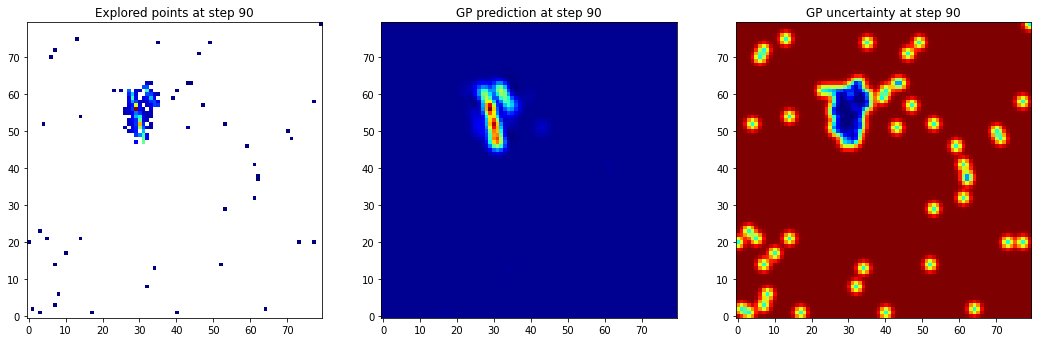

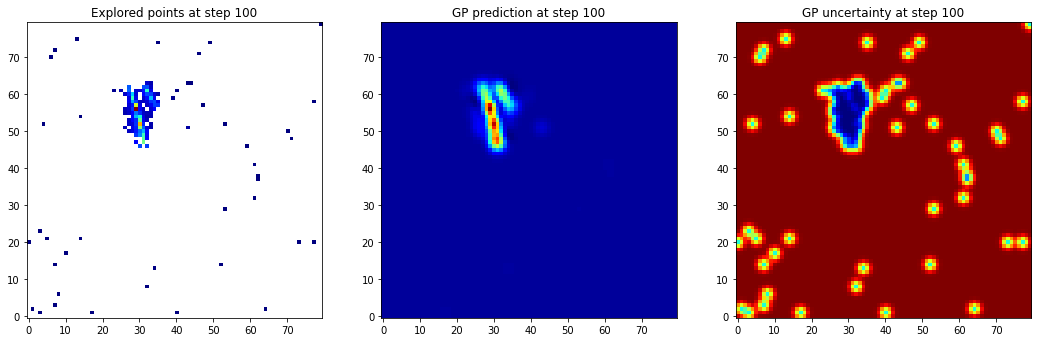

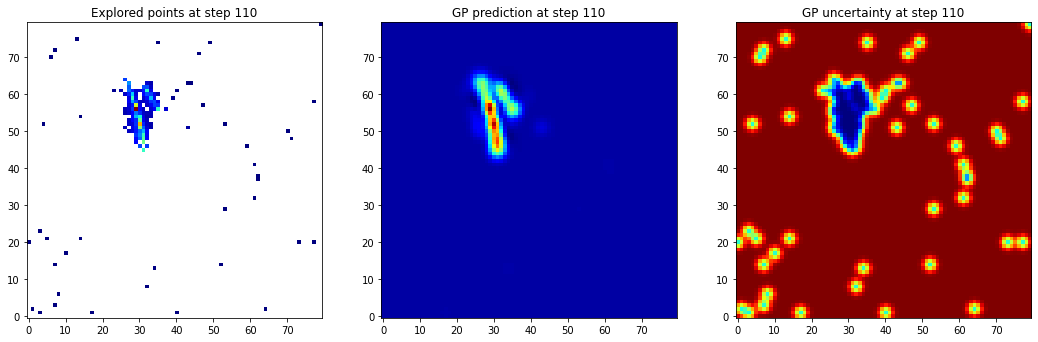

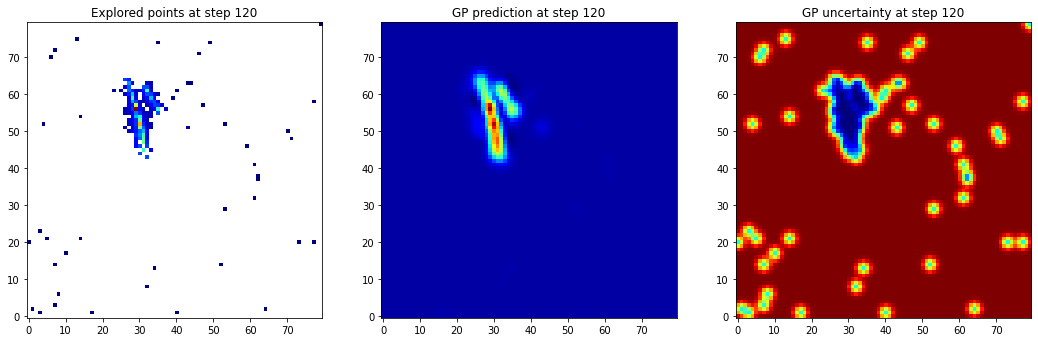

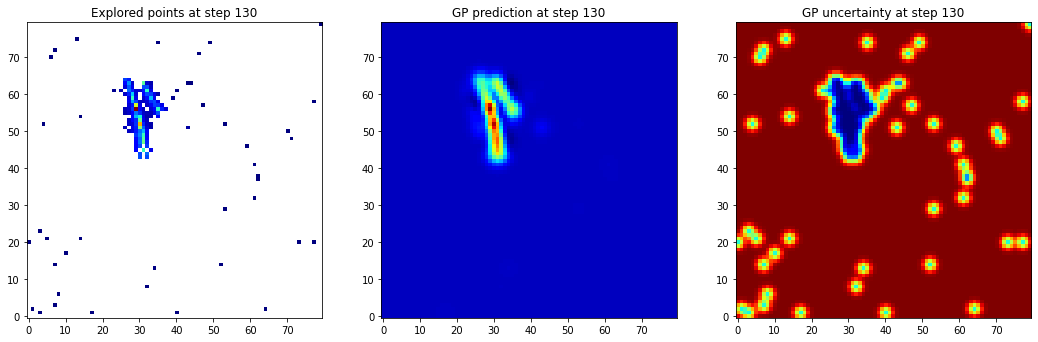

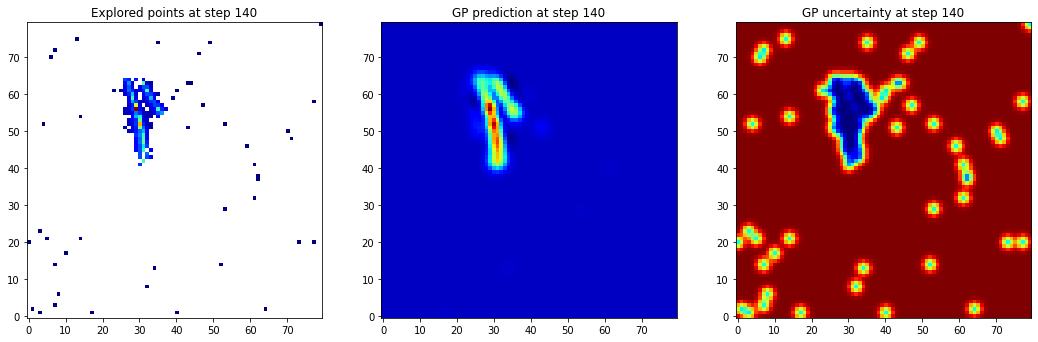

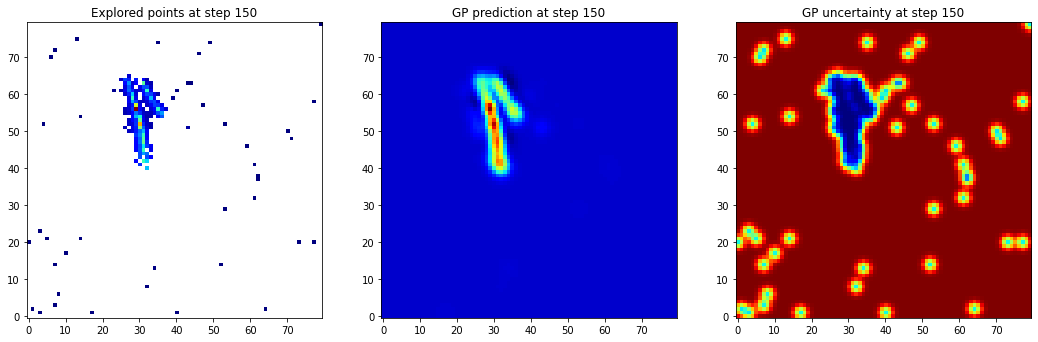

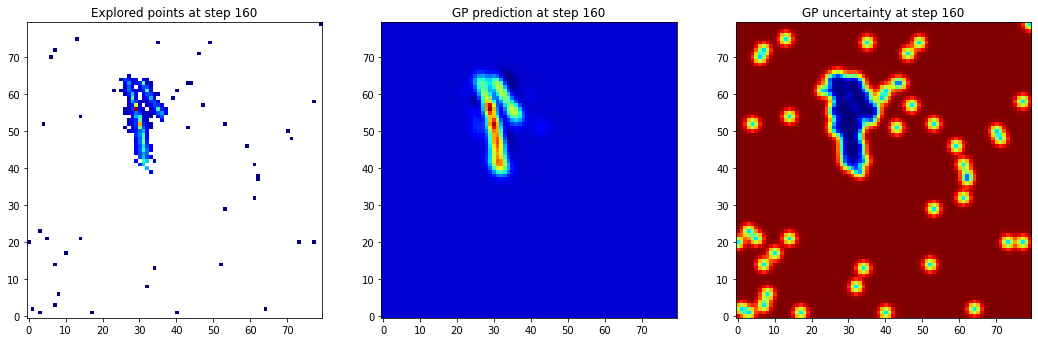

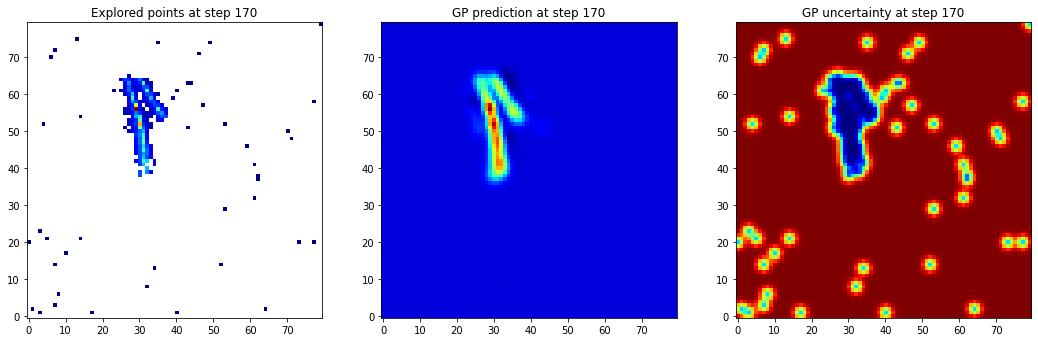

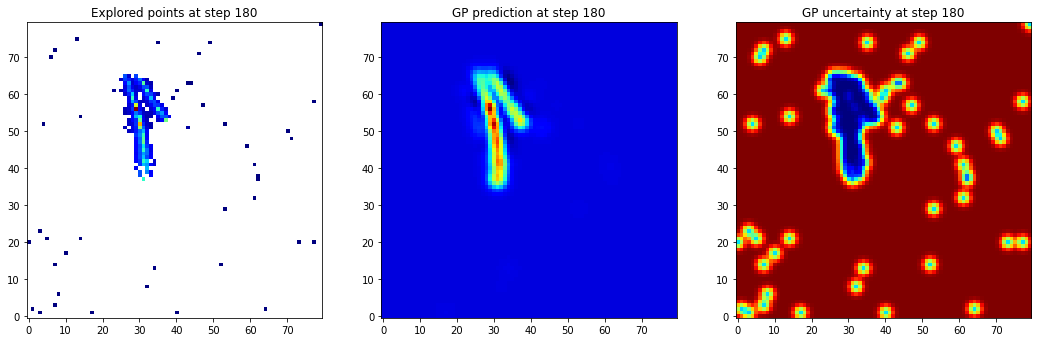

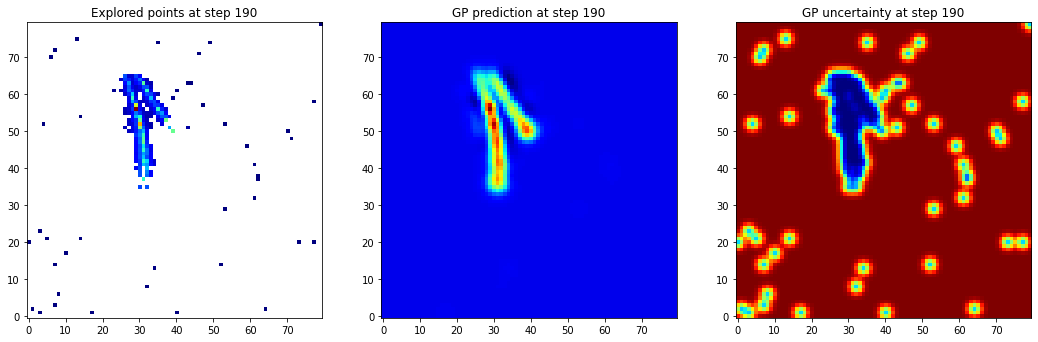

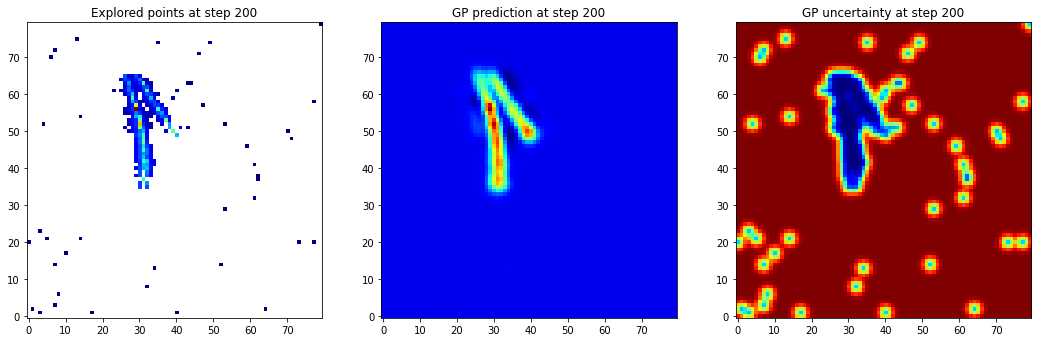

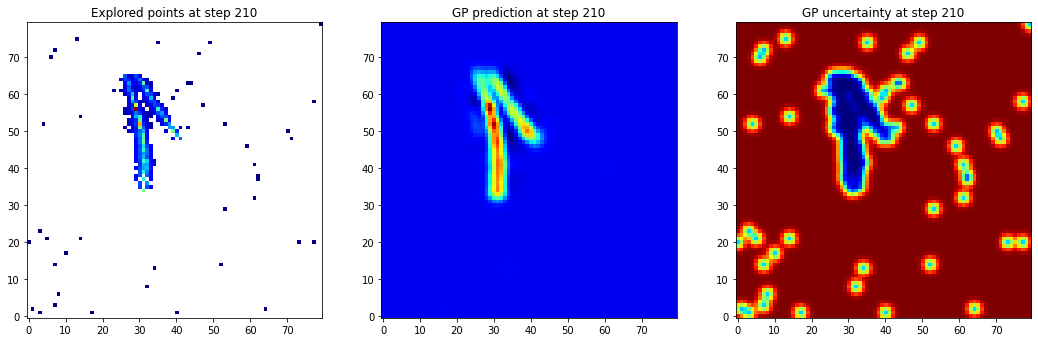

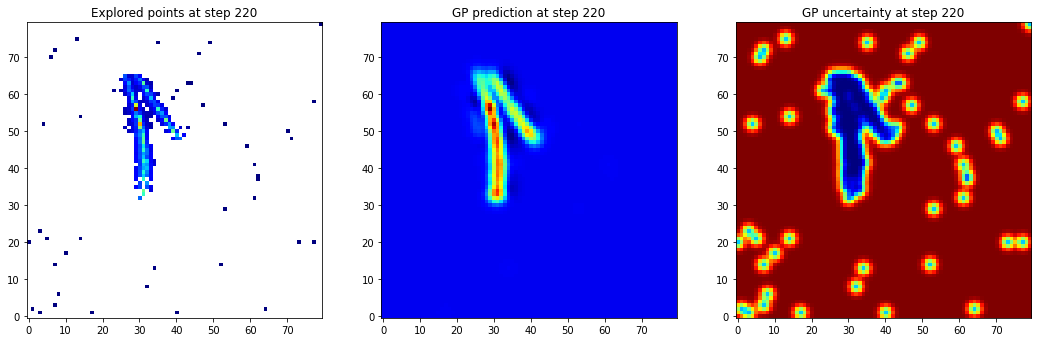

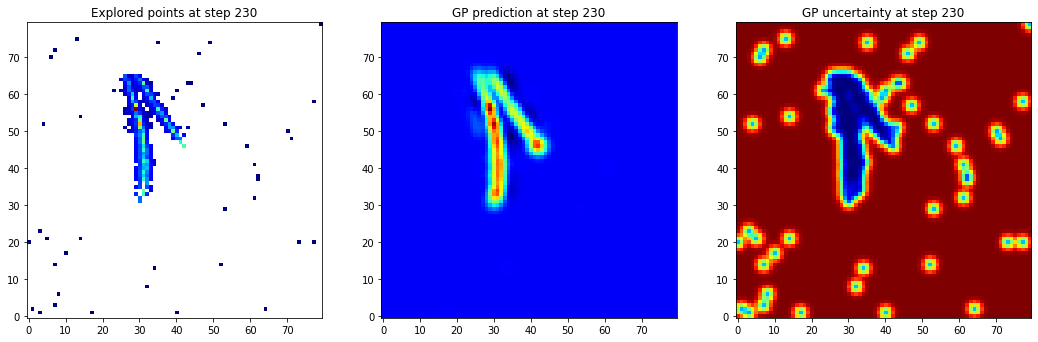

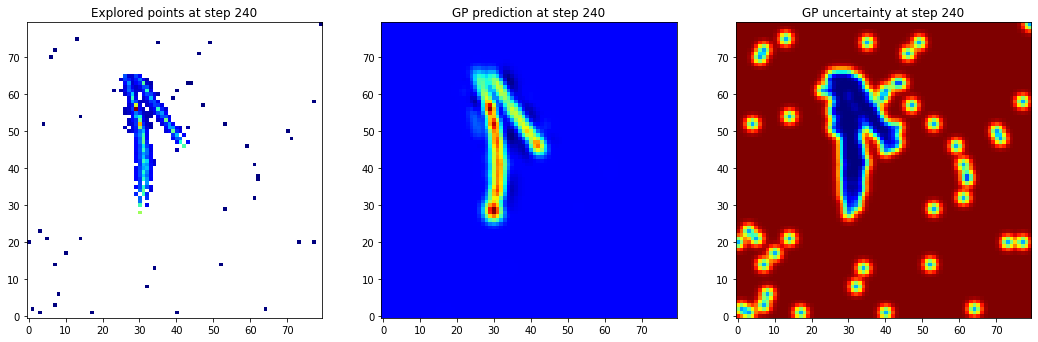

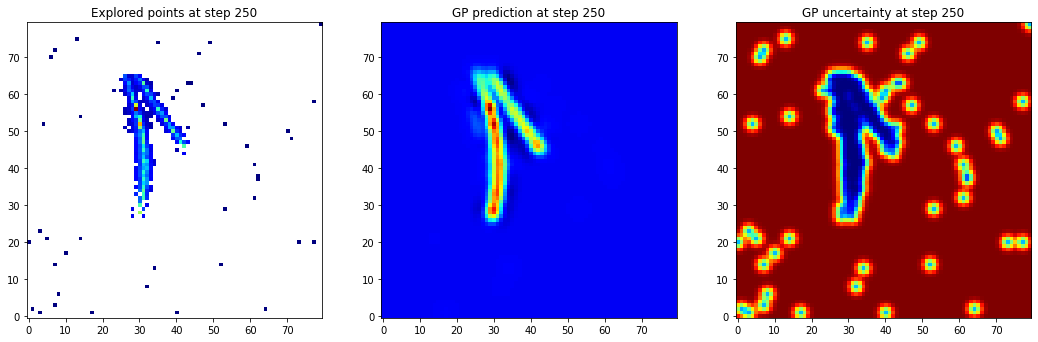

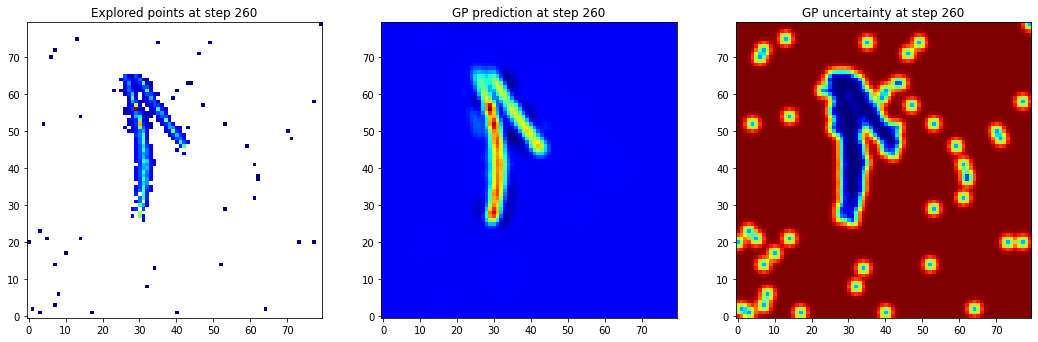

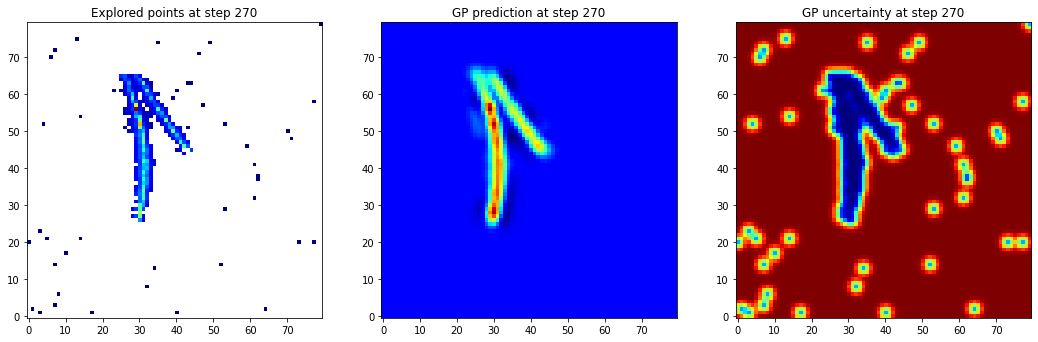

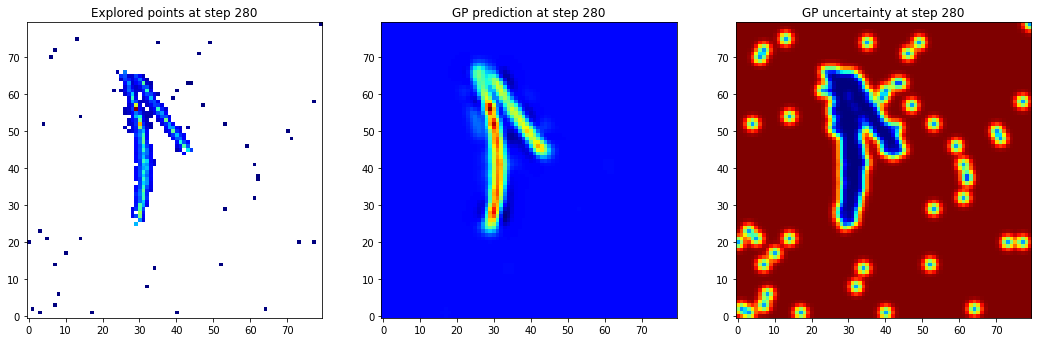

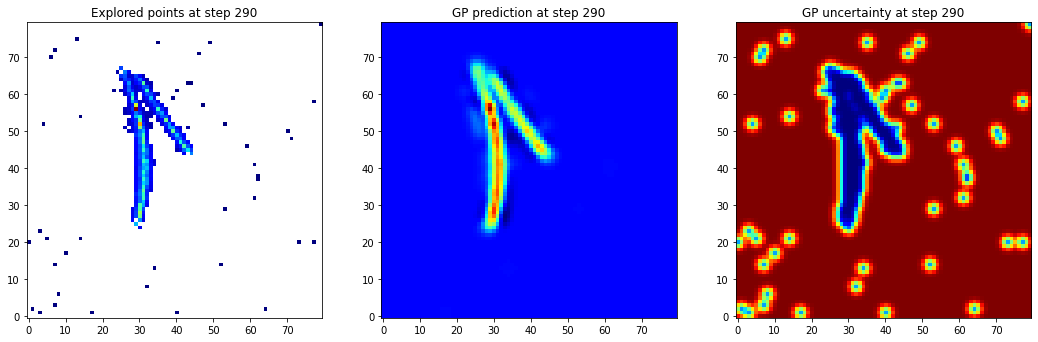

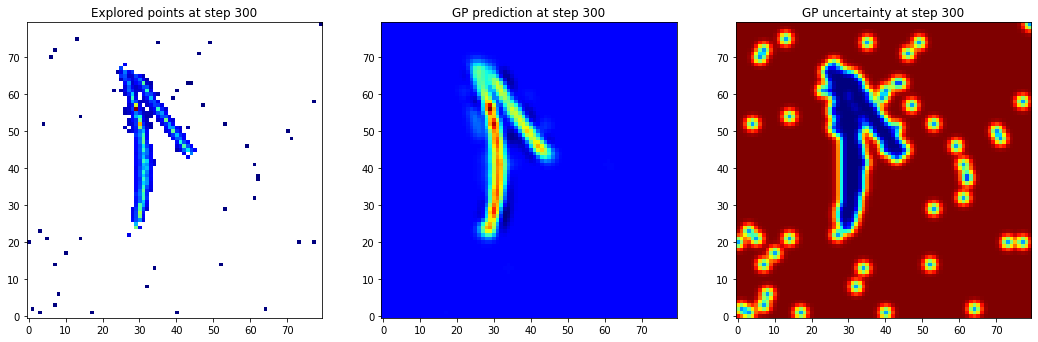

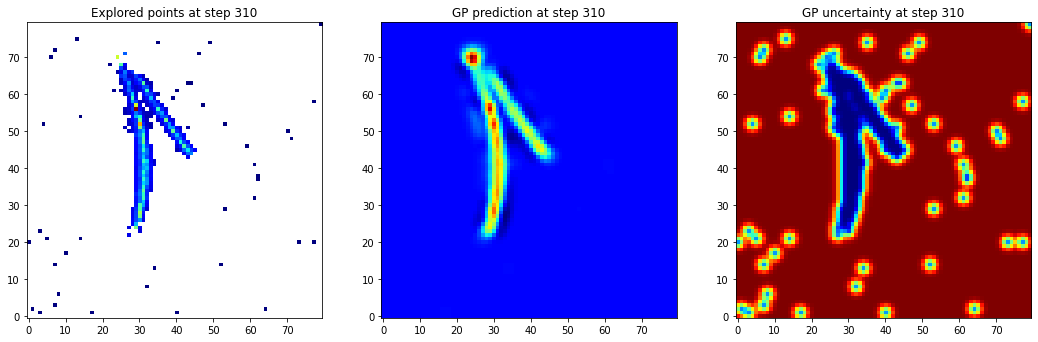

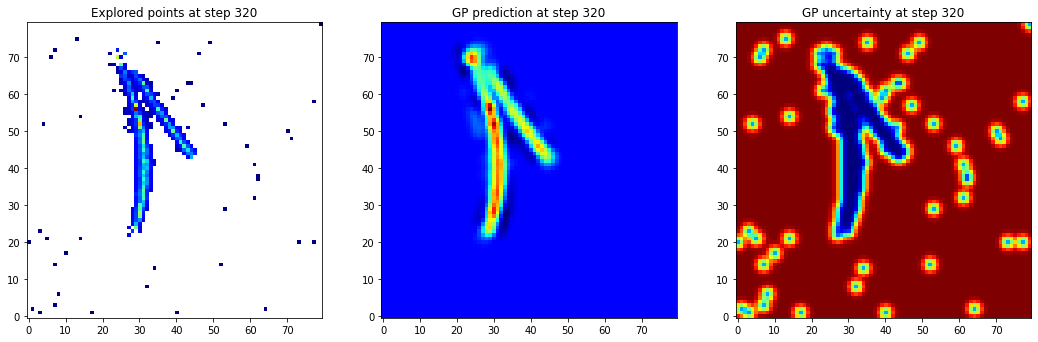

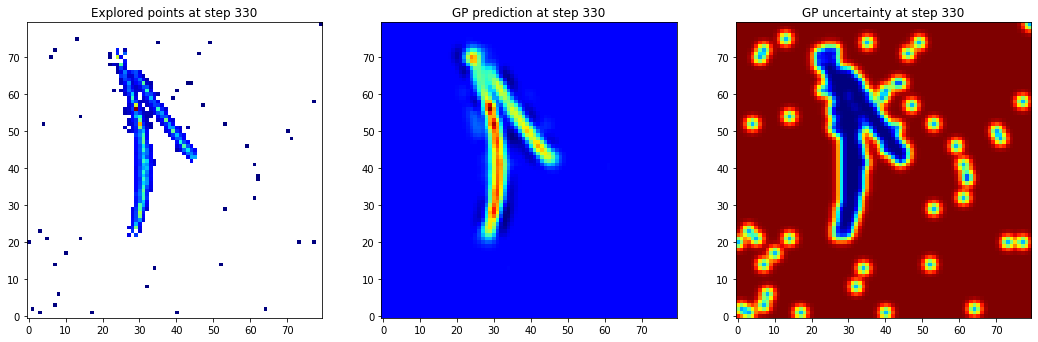

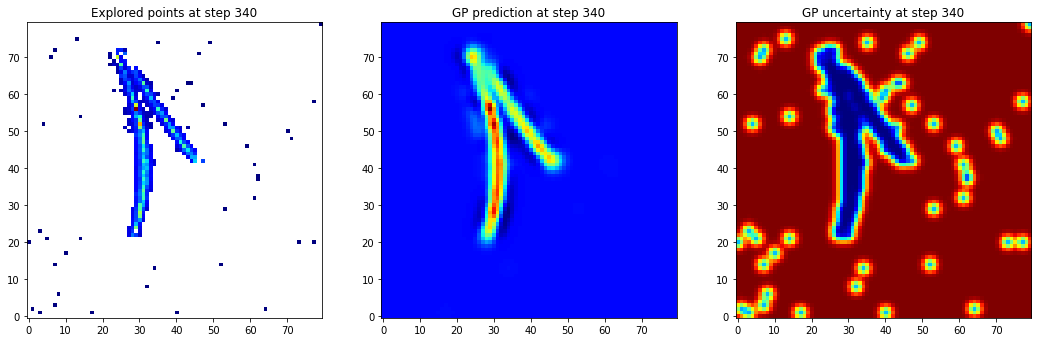

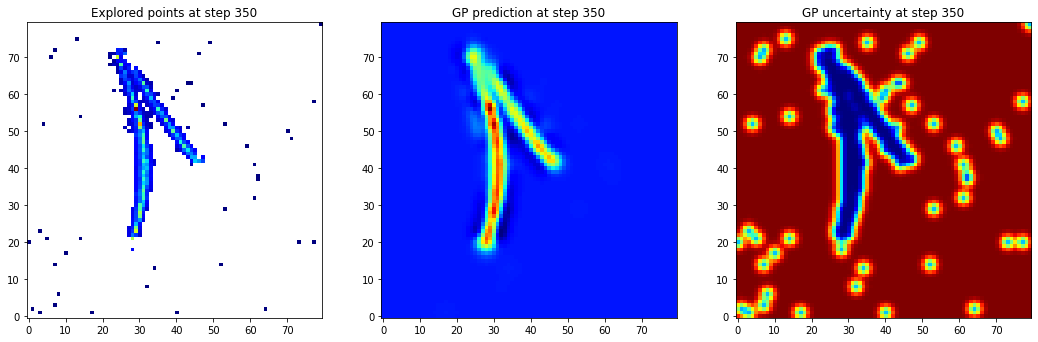

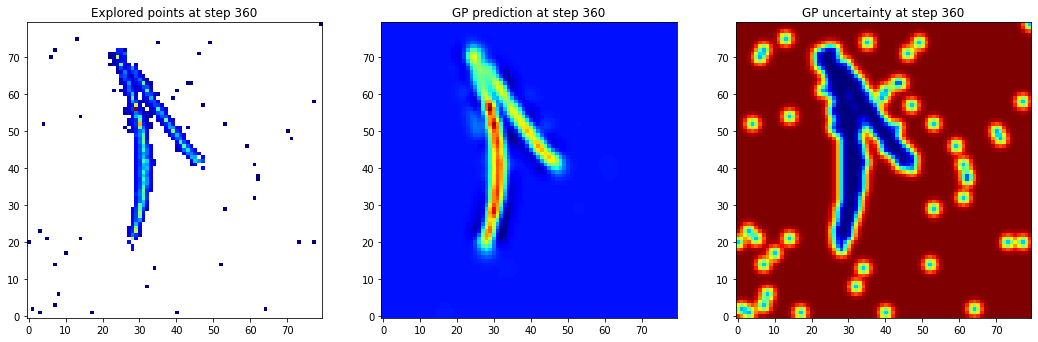

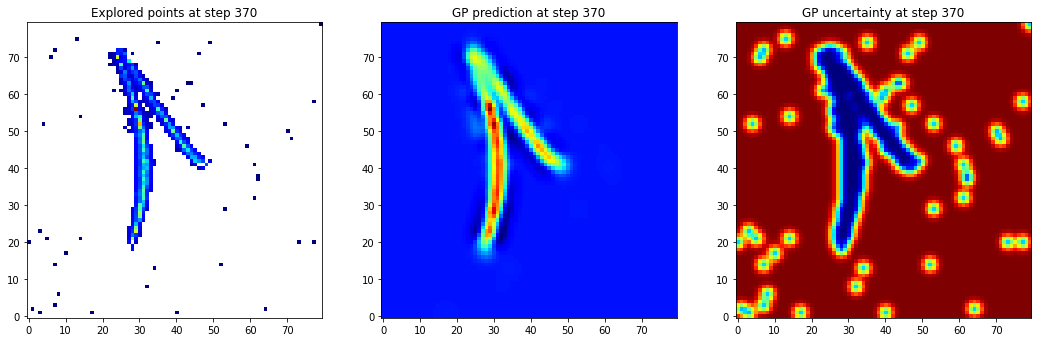

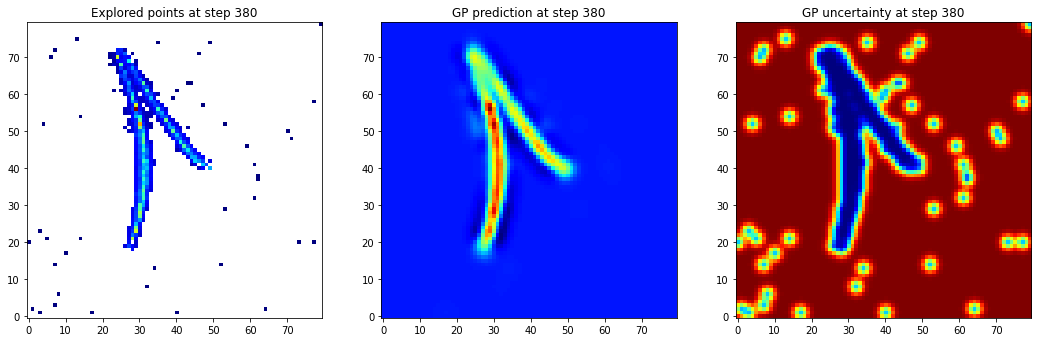

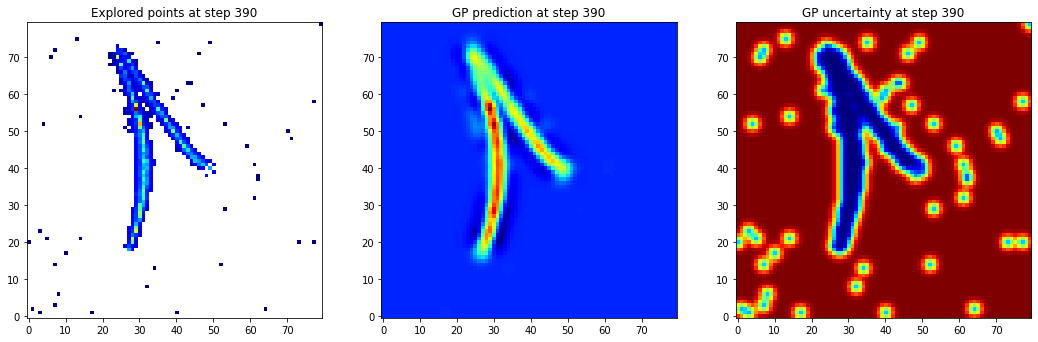

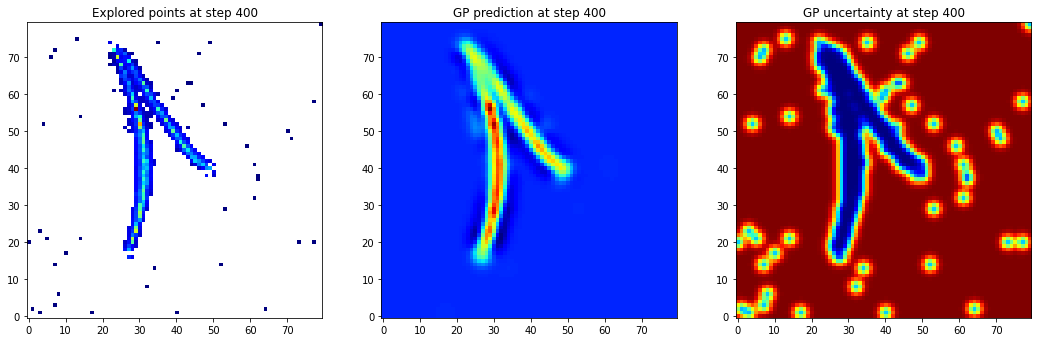

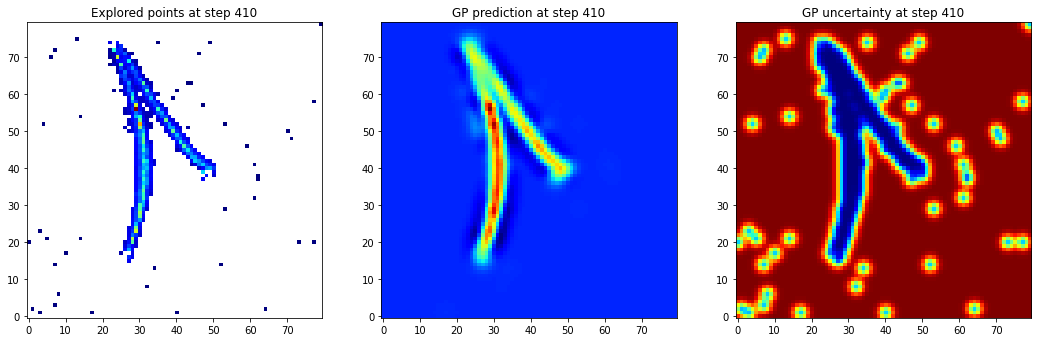

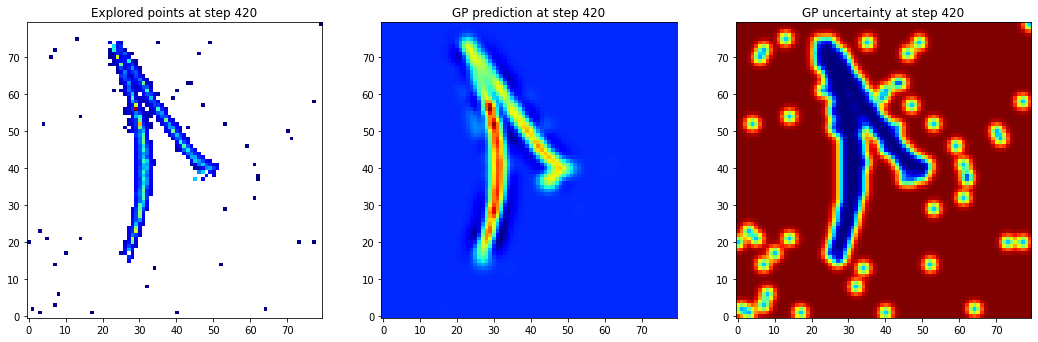

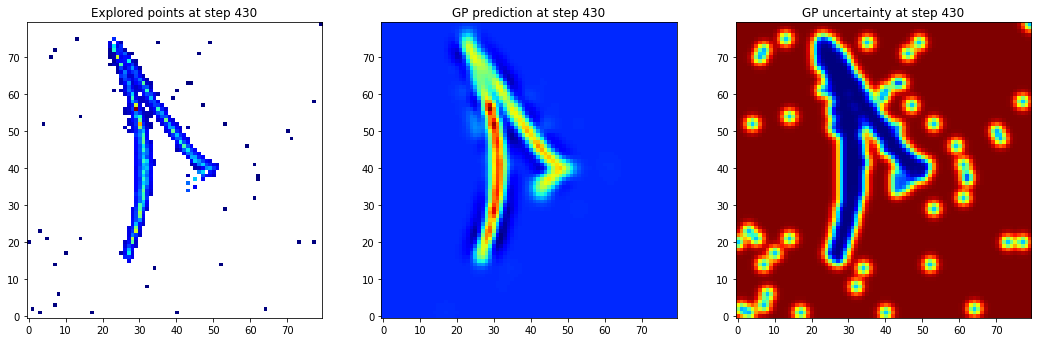

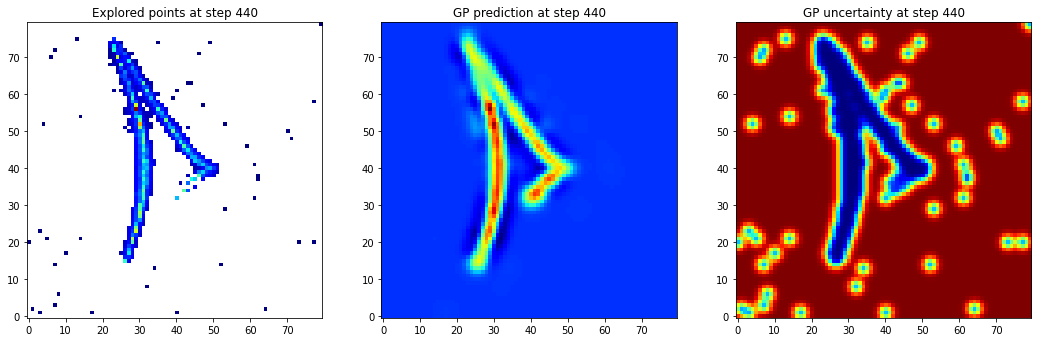

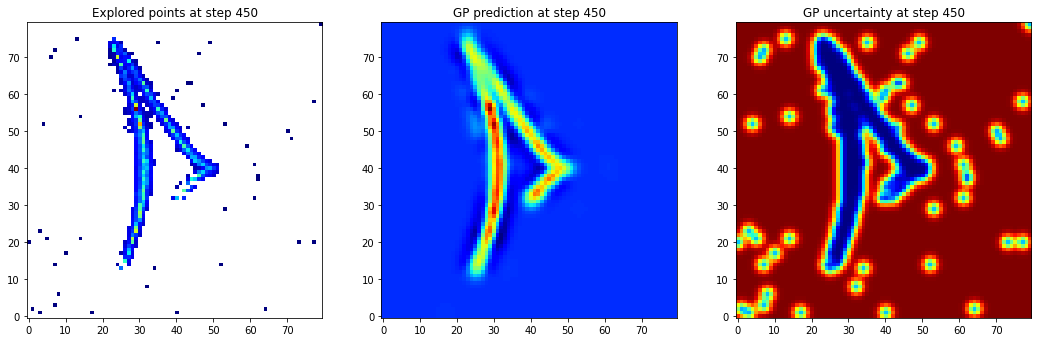

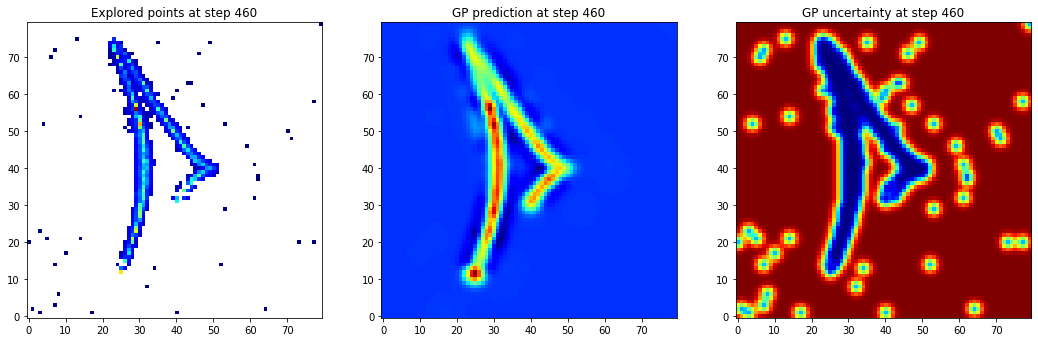

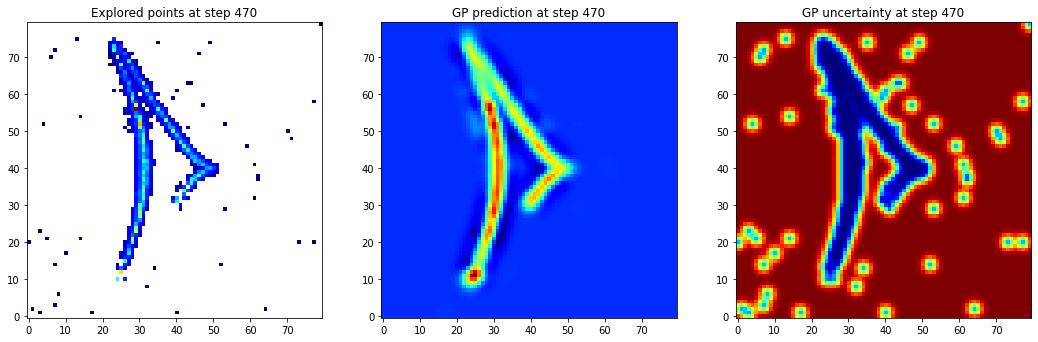

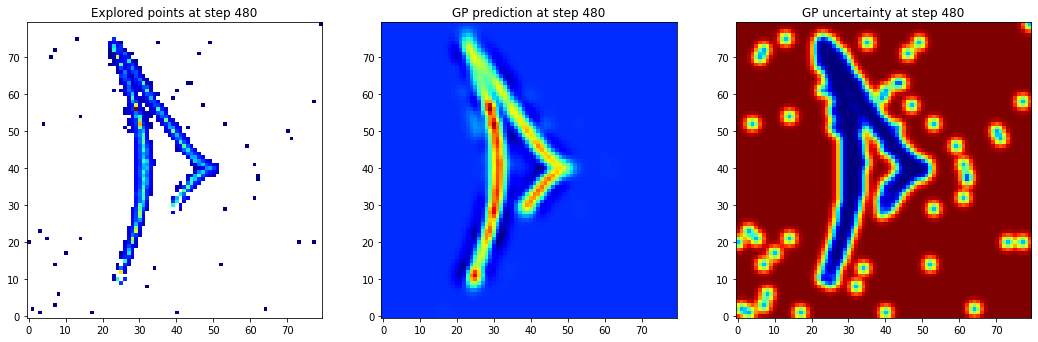

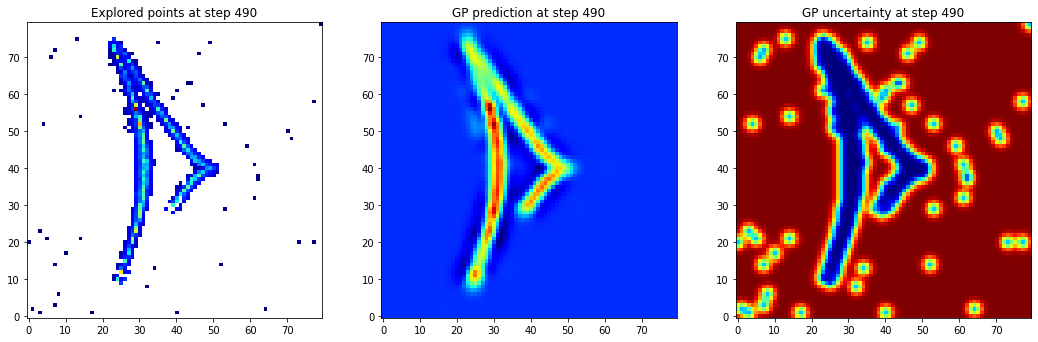

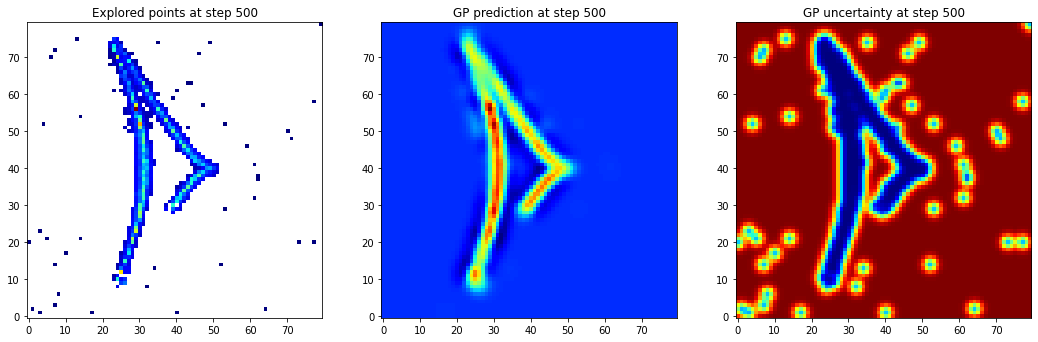

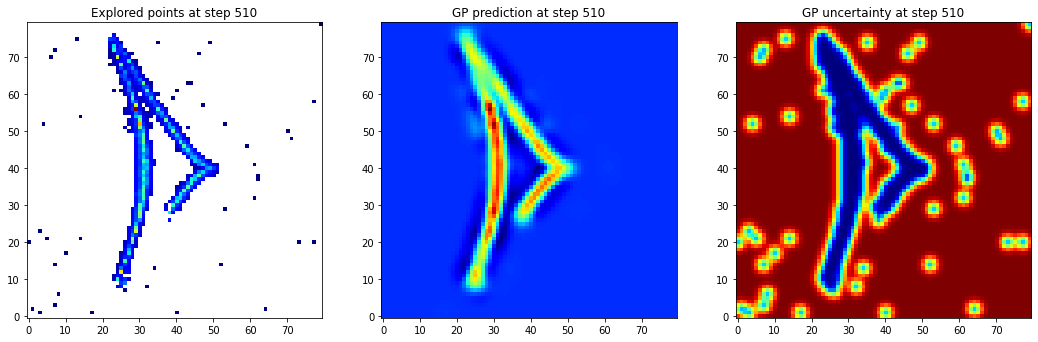

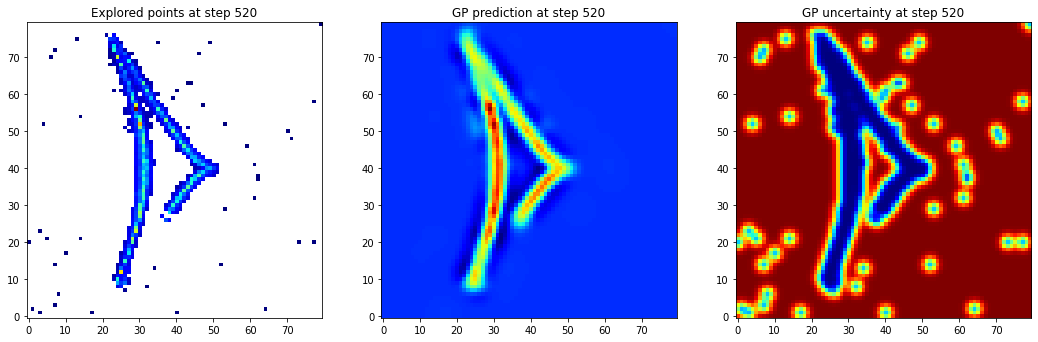

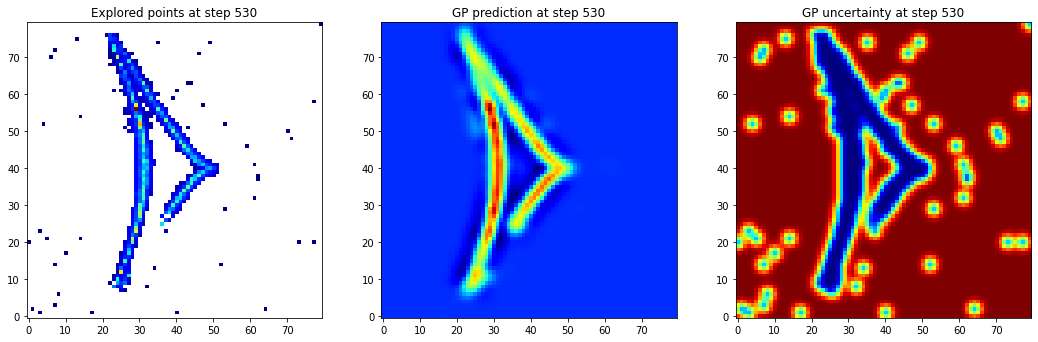

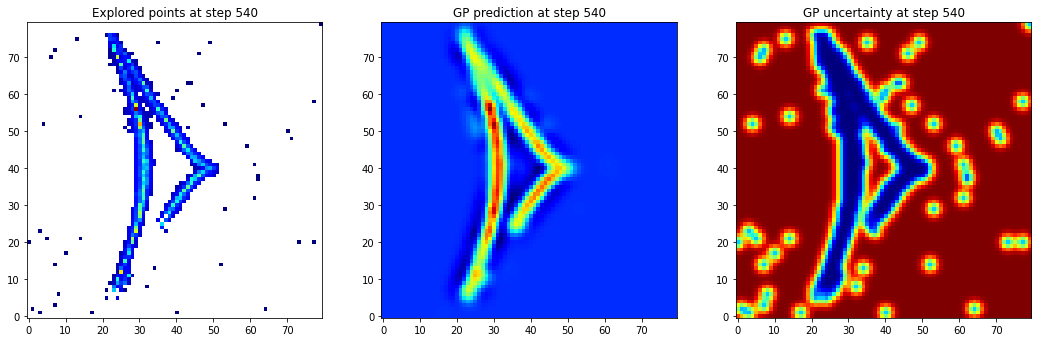

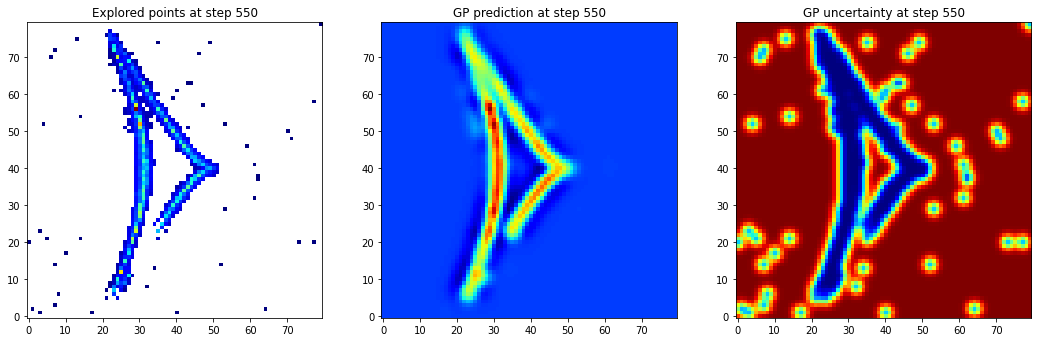

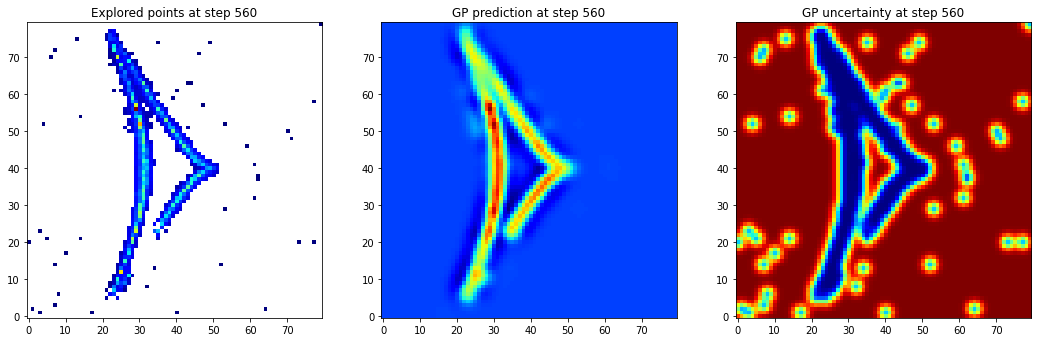

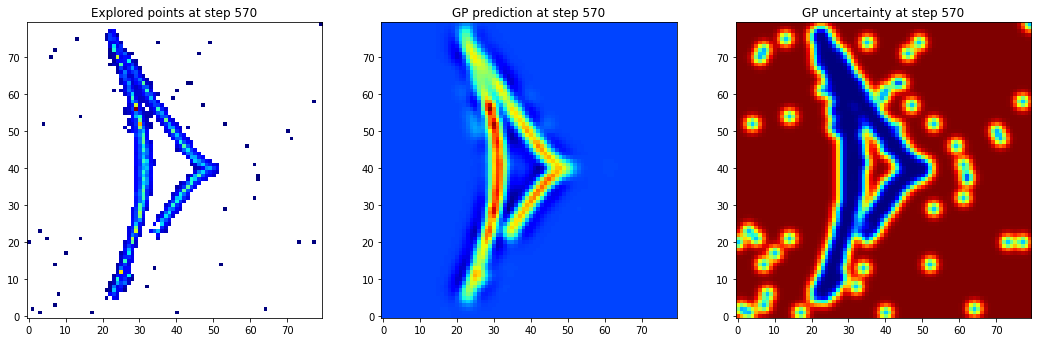

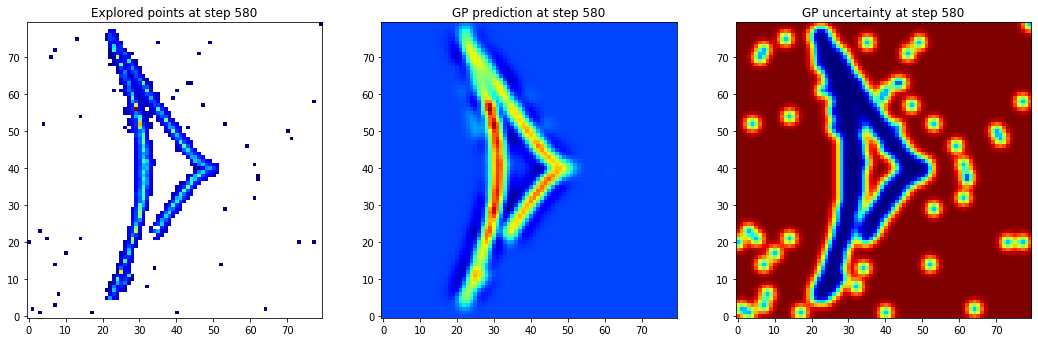

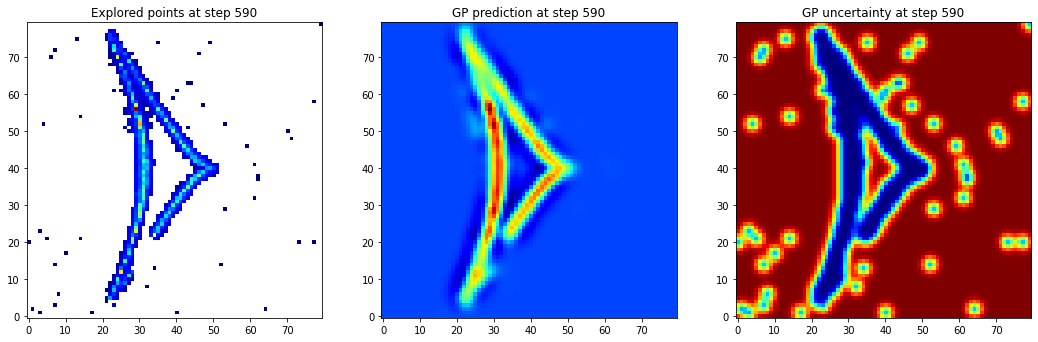

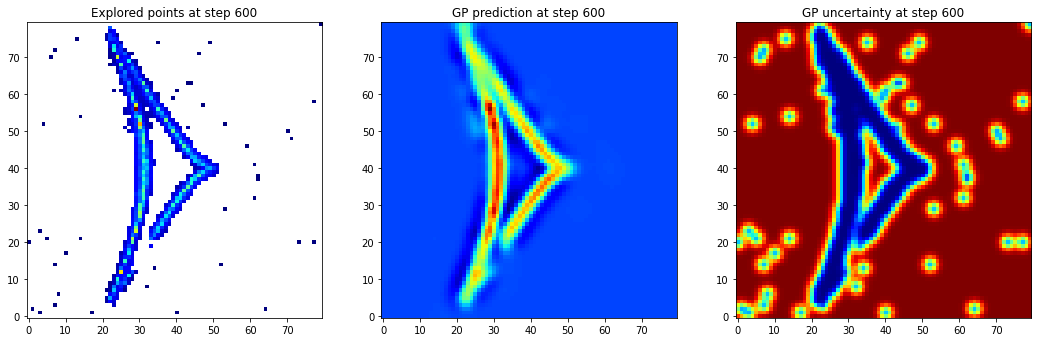

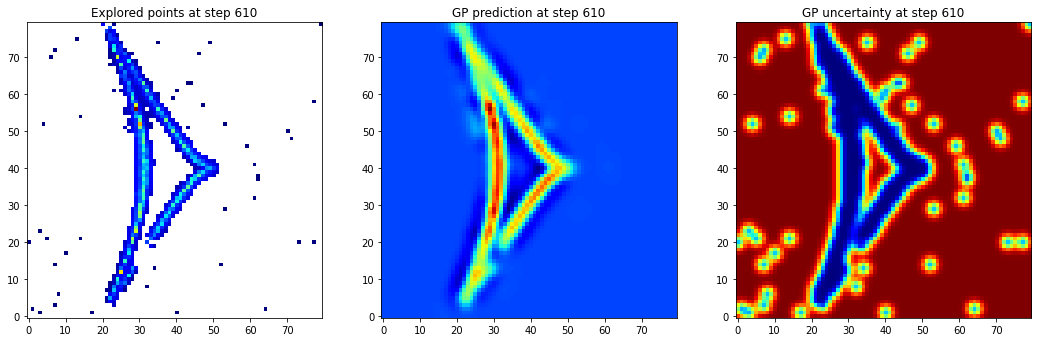

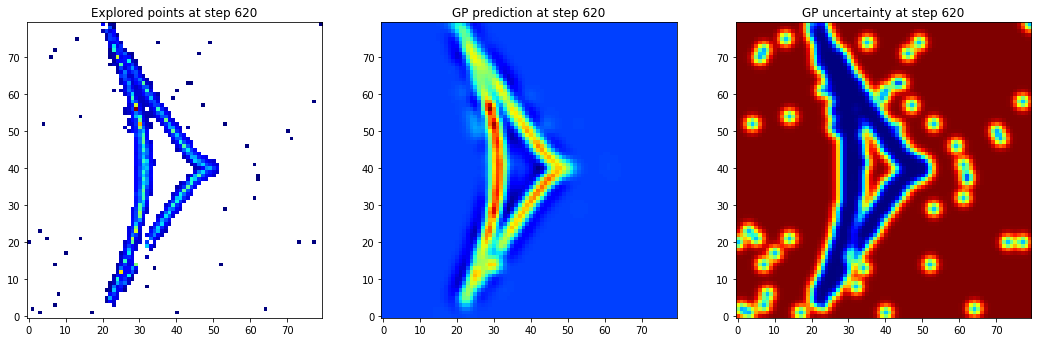

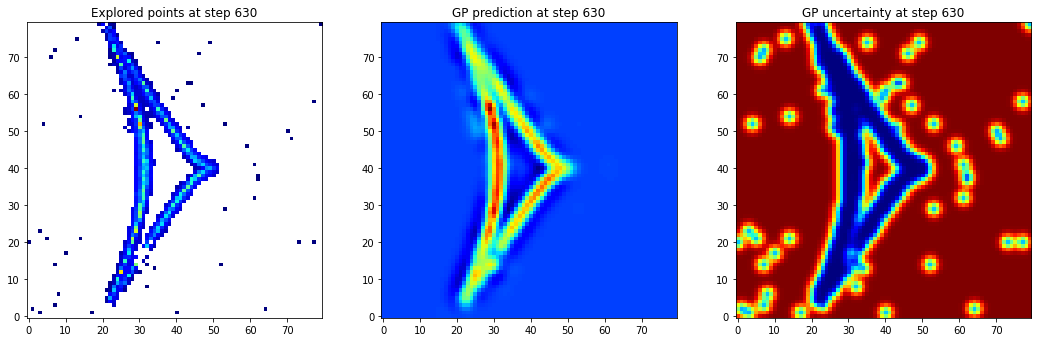

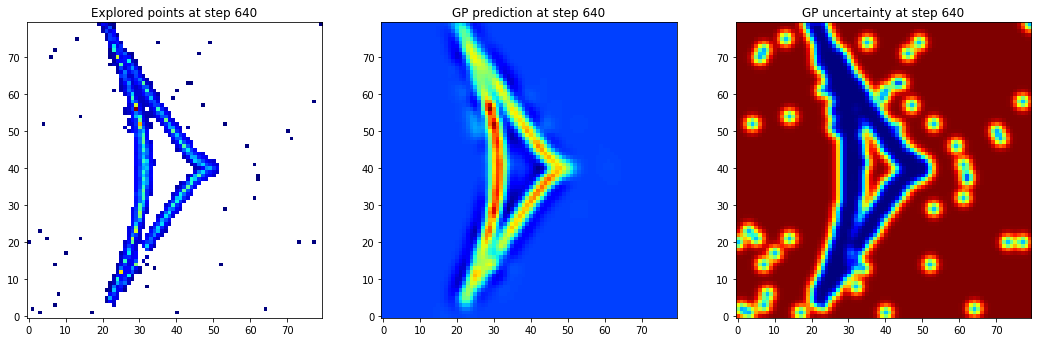

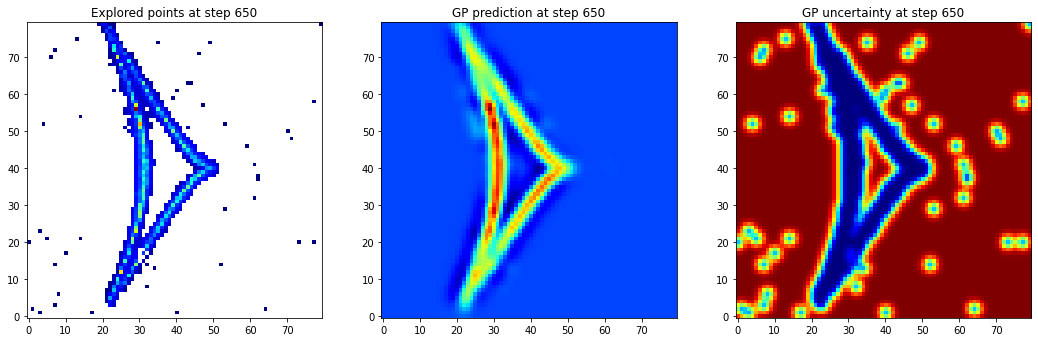

In [ ]:
 func_val, gp_pred = boptim.target_func_vals, boptim.gp_predictions
 vals_all = np.array(boptim.vals_all)
 inds_all = np.array(boptim.indices_all)
 for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
   if i % 10 == 0:
     _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
     ax1.imshow(func, origin='bottom', cmap='jet')
     ax2.imshow(pred[0], origin='bottom', cmap = "jet")
     ax3.imshow(pred[1], origin='bottom', cmap='jet')
     ax1.set_title('Explored points at step {}'.format(i))
     ax2.set_title('GP prediction at step {}'.format(i))
     ax3.set_title('GP uncertainty at step {}'.format(i))
     plt.show()